In [0]:
# tutorials
#https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn?irclickid=UQ-TzLznRxyKWRzVFH2NTzJqUkC0goxZ03Sa3Q0&irgwc=1&utm_medium=affiliate&utm_source=impact&utm_campaign=000000_1-2003851_2-mix_3-all_4-na_5-na_6-na_7-mp_8-affl-ip_9-na_10-bau_11-Bing%20Rebates%20by%20Microsoft&utm_content=BANNER&utm_term=EdgeBingFlow
#https://www.geeksforgeeks.org/k-nearest-neighbors-knn-regression-with-scikit-learn

## Import libraries

In [0]:
import pandas as pd
import numpy as np

# data prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# model creation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# model eval
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# plotting
import matplotlib.pyplot as plt

## Get data

In [0]:
spark.sql(f"""use commercialprospecting;""")
term_data1 = spark.sql(f"""
  SELECT distinct m.*,d.*,YEAR(m.MORTGAGEMATURITYDATE) - YEAR(m.MORTGAGEDATE) as Term
  FROM cremortgage m
  JOIN crepropdetail d on d.CREPROPERTYID = m.CREPROPERTYID
  WHERE m.MORTGAGEDATE > '2023-01-01'
  AND m.MORTGAGEMATURITYDATE IS NOT NULL
  AND d.LANDUSECATEGORY IN ('Commercial','Office','Multifamily','Retail')
""")

In [0]:
spark.sql(f"""use commercialprospecting;""")
term_data2 = spark.sql(f"""
  SELECT distinct m.MORTGAGEID,CAST(MORTGAGEAMOUNT / 1000000 as Double) as MORTGAGEAMOUNTMILLIONS,CAST(m.MORTGAGEPOSITION as Int),CAST(m.MORTGAGEINTERESTRATE as Double),m.MORTGAGERATETYPE,m.MORTGAGETYPE,m.MORTGAGELOANTYPE,m.MORTGAGEPURPOSE,CAST(m.PRIVATEPARTYLOAN as Int),d.LANDUSECATEGORY,CAST(d.OWNEROCCUPIED as Int),CAST(d.ASSESSEDLANDVALUE as Float),YEAR(m.MORTGAGEMATURITYDATE) - YEAR(m.MORTGAGEDATE) as Term
  FROM cremortgage m
  JOIN crepropdetail d on d.CREPROPERTYID = m.CREPROPERTYID
  WHERE m.MORTGAGEDATE > '2023-01-01'
  AND m.MORTGAGEMATURITYDATE IS NOT NULL
  AND d.LANDUSECATEGORY IN ('Commercial','Office','Multifamily','Retail')
""")

## Prep data

In [0]:
# convert to Pandas dataframe
term_data_pd2 = term_data2.toPandas()

# remove identifier MORTGAGEID
term_data_pd2 = term_data_pd2.drop(columns=['MORTGAGEID'])

# create binary columns for categorical variables
term_data_pd2 = pd.get_dummies(term_data_pd2,columns=['MORTGAGERATETYPE','MORTGAGETYPE','MORTGAGELOANTYPE','MORTGAGEPURPOSE','LANDUSECATEGORY'])

# move our target variable, Term, to end of dataframe
column = term_data_pd2.pop('Term')
term_data_pd2.insert(len(term_data_pd2.columns), 'Term', column)

## Feature selection

### Well-populated
See which fields are well-populated fields, since we'll need to drop NAs for our regressions. We also want the model to see more training data so that it knows how to handle more test data.

In [0]:
# convert to Pandas dataframe
term_data_pd1 = term_data1.toPandas()

nas = pd.DataFrame(term_data_pd1.isna().sum(),columns=['nulls'])
nas['ratio'] = nas['nulls'] / len(term_data_pd1)
best_fields = nas.sort_values('ratio')

/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [MORTGAGEPOSITION, MORTGAGEAMOUNT, MORTGAGEPROPCOUNT, MORTGAGEPROPVALUEASSESSED, MORTGAGEMATURITYYEAR, MORTGAGEINTERESTRATE, MORTGAGESELLERCARRYBACK, PRIVATEPARTYLOAN, PROPERTYAPNSEQ, MSAPUBLISHID, LATITUDE, LONGITUDE, PROPERTYBUILTYEAR, PROPERTYINACRES, PROPERTYBUILDINGSIZEINSQFT, PROPERTYBUILDINGCOUNT, LIVINGSQFT, NUMBEROFUNITS, NUMBEROFBEDROOMS, POOLFLAG, BESTPROPERTYVALUE, PROPERTYASSESSMENTYEAR, PROPERTYVALUEIMPROVEMENT, ASSESSEDLANDVALUE, ANNUALPROPERTYTAX, CORPORATEOWNED, OWNEROCCUPIED, CRETRANSACTIONPRICE, MULTIPROPERTYINDICATOR, TRANSACTIONPROPCOUNT, TRANSACTIONPROPVALASSESSED, PRIORSALEPRICE, OPENMORTGAGELIENCOUNT, OPENMORTGAGELIENAMOUNT, LOANTOVALUERATIO] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


In [0]:
pd.set_option('display.max_rows', None)
best_fields

,nulls,ratio
PROPERTYMORTGAGEID,0,0.000000
MULTIPROPERTYINDICATOR,0,0.000000
OWNEROCCUPIED,0,0.000000
LANDUSEPROPERTYCATEGORY,0,0.000000
LANDUSECATEGORY,0,0.000000
COUNTYID,0,0.000000
PROPERTYSTATE,0,0.000000
PROPERTYAPNSEQ,0,0.000000
PROPERTYAPNFORMATTED,0,0.000000
CREPROPERTYID,0,0.000000


### Correlation with target variable

In [0]:
# Filter out non-numeric columns before applying the correlation function
numeric_cols = term_data_pd2.select_dtypes(include=[np.number])
corrs = numeric_cols.apply(lambda x: x.corr(numeric_cols['Term']))
corrs

Out[172]: MORTGAGEAMOUNTMILLIONS                                           -0.011996
MORTGAGEPOSITION                                                 -0.097868
MORTGAGEINTERESTRATE                                              0.165146
PRIVATEPARTYLOAN                                                 -0.160262
OWNEROCCUPIED                                                     0.141623
ASSESSEDLANDVALUE                                                -0.062537
MORTGAGERATETYPE_Adjustable                                       0.155839
MORTGAGERATETYPE_Adjusted National Avg                           -0.001546
MORTGAGERATETYPE_Fixed                                            0.064311
MORTGAGERATETYPE_Fixed National Avg                              -0.043070
MORTGAGETYPE_Junior                                              -0.199136
MORTGAGETYPE_Purchase                                             0.221622
MORTGAGETYPE_Refinancing                                         -0.020201
MORTGAGELOANTYP

In [0]:
threshold = 0.1
selector = VarianceThreshold(threshold)
selector.fit(term_data_pd2)
high_var_indices = selector.get_support(indices=True)
selected_data = term_data_pd2.iloc[:,high_var_indices]
pd.set_option('display.max_rows', 100)
selected_data

,MORTGAGEPOSITION,PRIVATEPARTYLOAN,OWNEROCCUPIED,ASSESSEDLANDVALUE,MORTGAGETYPE_Junior,MORTGAGETYPE_Purchase,MORTGAGETYPE_Refinancing,MORTGAGELOANTYPE_Conventional,MORTGAGELOANTYPE_Private Party Lender,MORTGAGEPURPOSE_New First Mortgage,MORTGAGEPURPOSE_Standalone Subordinate,MORTGAGEPURPOSE_Undetermined First Mortgage,MORTGAGEPURPOSE_Undetermined Standalone Subordinate,Term
0,2,0,1,60017.0,1,0,0,1,0,0,1,0,0,0
1,2,0,0,858500.0,1,0,0,1,0,0,1,0,0,3
2,1,1,0,412950.0,0,1,0,0,1,1,0,0,0,4
3,1,1,1,47690.0,0,0,1,0,1,0,0,1,0,30
4,2,1,0,3700.0,1,0,0,0,1,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76251,1,0,0,182952.0,0,0,1,0,0,0,0,0,0,30
76252,1,0,1,100000.0,1,0,0,1,0,0,1,0,0,2
76253,1,0,0,446900.0,1,0,0,1,0,0,1,0,0,5
76254,1,0,0,154202.0,0,1,0,1,0,1,0,0,0,19


## Train and test models

In [0]:
def test_model(model_name,X_train,y_train,X_test,y_test):
  model_name.fit(X_train,y_train)
  # make predictions on test data
  y_pred = model_name.predict(X_test)
  # evaluate model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f'Mean Squared Error: {mse}')
  print(f'R-squared: {r2}')

In [0]:
data = term_data_pd2.dropna(how='any',axis=0).to_numpy()

X = data[:,:-1]
y = data[:,-1]
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,train_size=0.8,shuffle=True)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
len(X_train) ** (1/2)

Out[175]: 271.82163269320563

In [0]:
knn = KNeighborsRegressor(n_neighbors=270)
test_model(knn,X_train,y_train,X_test,y_test)

Mean Squared Error: 76.70958550248595
R-squared: 0.41030634491873597


In [0]:
rf = RandomForestRegressor(random_state=0)
test_model(rf,X_train,y_train,X_test,y_test)

Mean Squared Error: 48.76485522452451
R-squared: 0.6251273484468689


In [0]:
lr = LinearRegression()
test_model(lr,X_train,y_train,X_test,y_test)

Mean Squared Error: 84.41411725564333
R-squared: 0.35107889035164275


In [0]:
# TODO:
# we could also try a k-means regression
# replicate Chris' analyses
# combine deduplication methods; dissect id values

## Use model to fill in missing values

In [0]:
# split into rows that have a maturity date and those that don't
# not_nulls = cre_data.filter(cre_data.MatureYear.isNotNull())
# nulls = cre_data.filter(cre_data.MatureYear.isNull())

In [0]:
spark.sql(f"""use commercialprospecting;""")
missing_data = spark.sql(f"""
  SELECT distinct m.MORTGAGEID,d.LANDUSECATEGORY,CAST(m.MORTGAGEAMOUNT / 1000000 as Double) as MORTGAGEAMOUNTMILLIONS
  FROM cremortgage m
  JOIN crepropdetail d on d.CREPROPERTYID = m.CREPROPERTYID
  WHERE m.MORTGAGEMATURITYDATE IS NULL
  AND d.LANDUSECATEGORY IN ('Commercial','Office','Multifamily','Retail')
""")

missing_data_pd = missing_data.toPandas()

# remove identifier MORTGAGEID
missing_data_pd2 = missing_data_pd.drop(columns=['MORTGAGEID'])

# create binary columns for categorical variable
missing_data_pd2 = pd.get_dummies(missing_data_pd2,columns=['LANDUSECATEGORY'])

missing_test = missing_data_pd2.to_numpy()
imputer = SimpleImputer(strategy='mean')
missing_test = imputer.fit_transform(missing_test)

y_pred = knn_regressor.predict(missing_test)

## Evaluate model

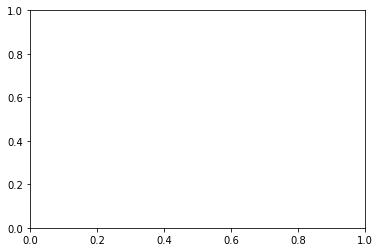

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-4336958134104935>:2
      1 # visualize the results
----> 2 plt.scatter(X_test, y_test, color='blue', label='Actual')
      3 plt.scatter(y_test, y_pred, color='red', label='Predicted')
      4 plt.title('KNN Regression')

File /databricks/python/lib/python3.9/site-packages/matplotlib/pyplot.py:2807, in scatter(x, y, s, c, marker, cmap, norm, vmin, vmax, alpha, linewidths, edgecolors, plotnonfinite, data, **kwargs)
   2802 @_copy_docstring_and_deprecators(Axes.scatter)
   2803 def scatter(
   2804         x, y, s=None, c=None, marker=None, cmap=None, norm=None,
   2805         vmin=None, vmax=None, alpha=None, linewidths=None, *,
   2806         edgecolors=None, plotnonfinite=False, data=None, **kwargs):
-> 2807     __ret = gca().scatter(
   2808         x, y, s=s, c=c, marker=marker, cmap=cmap, norm=norm,
   2809         

In [0]:
# visualize the results
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(y_test, y_pred, color='red', label='Predicted')
plt.title('KNN Regression')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

## Model Tuning
https://pyihub.org/hyperparameter-tuning-of-knn

In [0]:
error_rate = []

for i in range(1, 1000, 50):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    # testing the model
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    #r2 = r2_score(y_test, y_pred)
    error_rate.append(mse)
    
# Configure and plot error rate over k values
plt.figure(figsize=(10,4))
plt.plot(range(1, 1000), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='green', markersize=10)

#plotting knn graph
plt.title('Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

In [0]:
# importing the gridsearchcv for hyperparameter tuning of KNN
grid_params = { 'n_neighbors' : [5,10,15,20,25,30],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

# initializing the hyperparameter tuning of KNN

gs = GridSearchCV(KNeighborsRegressor(), grid_params, verbose = 1, cv=3, n_jobs = -1)

# fit the model on our train set
g_res = gs.fit(X_train, y_train)

# get the hyperparameters with the best score
g_res.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Out[52]: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}

### Legacy code

In [0]:
def find_outliers(df,col_name):
  
  q1 = df[col_name].quantile(0.25)
  q3 = df[col_name].quantile(0.75)
  IQR = q3 - q1
  outliers = df[(df[col_name] > (q3 + 1.5 * IQR)) | (df[col_name] < (q1 - 1.5 * IQR))]  
  return outliers

In [0]:
# remove outliers
#outliers = find_outliers(term_data_pd,'Term')
#no_outliers = term_data_pd.drop(outliers.index)

#no_outliers2 = no_outliers.drop(columns=['MORTGAGEID']) 
#no_outliers2 = pd.get_dummies(no_outliers2,columns=['LANDUSECATEGORY'])
# move Term to end of dataframe
#column = no_outliers2.pop('Term')
#no_outliers2.insert(len(no_outliers2.columns), 'Term', column)

#data = no_outliers2.dropna(how='any',axis=0)
#data = no_outliers2.to_numpy()

In [0]:
#X_train = np.array(X_train, dtype=float)
# Replace infinity values with NaN
#X_train = np.where(np.isinf(X_train), np.nan, X_train)
# Impute missing values (NaN) with the mean of the column
#imputer = SimpleImputer(strategy='mean')
#X_train = imputer.fit_transform(X_train)
# convert text column LANDUSECATEGORY to numeric
#label_binarizer = LabelBinarizer() 
#label_binarizer_output = label_binarizer.fit_transform(no_outliers2['LANDUSECATEGORY'])
# creating a data frame from the object
#result_df = pd.DataFrame(label_binarizer_output, columns = label_binarizer.classes_) 

In [0]:
#drop unnecessary columns
no_outliers2 = no_outliers.drop(columns=['MORTGAGEID', 'CREPROPERTYID', 'PROPERTYAPNFORMATTED', 'PROPERTYAPNSEQ',
       'PROPERTYSTREET', 'PROPERTYCITY', 'PROPERTYSTATE', 'PROPERTYZIP',
       'PROPERTYZIP4', 'COUNTYID', 'COUNTYNAME', 'COUNTYTYPE', 'CENSUSTRACT',
       'MSAPUBLISHID', 'MSANAME', 'MSATYPE', 'LATITUDE', 'LONGITUDE','MAILINGSTREET', 'MAILINGCITY',
       'MAILINGSTATE', 'MAILINGZIP', 'MAILINGZIP4','CRETRANSACTIONDATE','TRANSACTIONRECDATE','PRIORSALEDATE','MORTGAGEDATE','LANDUSEPROPERTYCATEGORY','DEEDTYPE','MORTGAGELOANTYPE','MORTGAGERATETYPE','PROPERTYOWNERSHIPRIGHT','PROPERTYBUILTYEAR','PROPERTYASSESSMENTYEAR','PROPERTYOWNERSHIPRIGHT'])

In [0]:
#print("Original DataFrame Shape:", term_data_pd.shape)
#print("DataFrame Shape after Removing Outliers:", no_outliers.shape)

Original DataFrame Shape: (27667, 60)
DataFrame Shape after Removing Outliers: (27649, 60)


Out[100]: <seaborn.axisgrid.FacetGrid at 0x7f6a62a7d520>

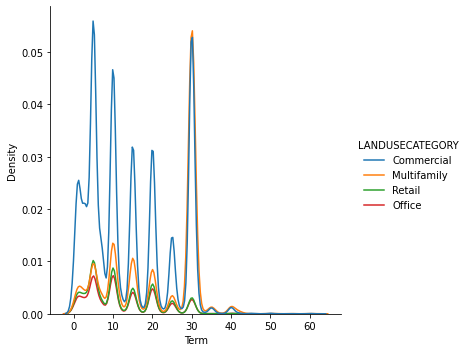

In [0]:
sns.displot(no_outliers, x="Term", hue="LANDUSECATEGORY", kind="kde")
#sns.histplot(no_outliers, x="Term", shrink=0.8, hue="LANDUSECATEGORY")